In [2]:
import json
import sys

sys.path.append("/workspace/circuit-finder")
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results" / "leap_experiment" / "batch_0"
assert results_dir.exists()

# Print Hparams

In [3]:
config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/greaterthan_gpt2-small_prompts.json
save_dir: results/leap_experiment
seed: 1
batch_size: 4
total_dataset_size: 1024
ablate_errors: False
first_ablate_layer: 2
verbose: False


# Show Dataset

In [5]:
# import pandas as pd
# pd.set_option('display.max_colwidth', None)

# dataset = results_dir / "dataset.json"
# with open(dataset, 'r') as f:
#     dataset = json.load(f)

# df = pd.DataFrame(dataset)
# df.head()

# Plot Graph

Threshold: 0.001, n_edges: 1717


Threshold: 0.003, n_edges: 163
Threshold: 0.006, n_edges: 59


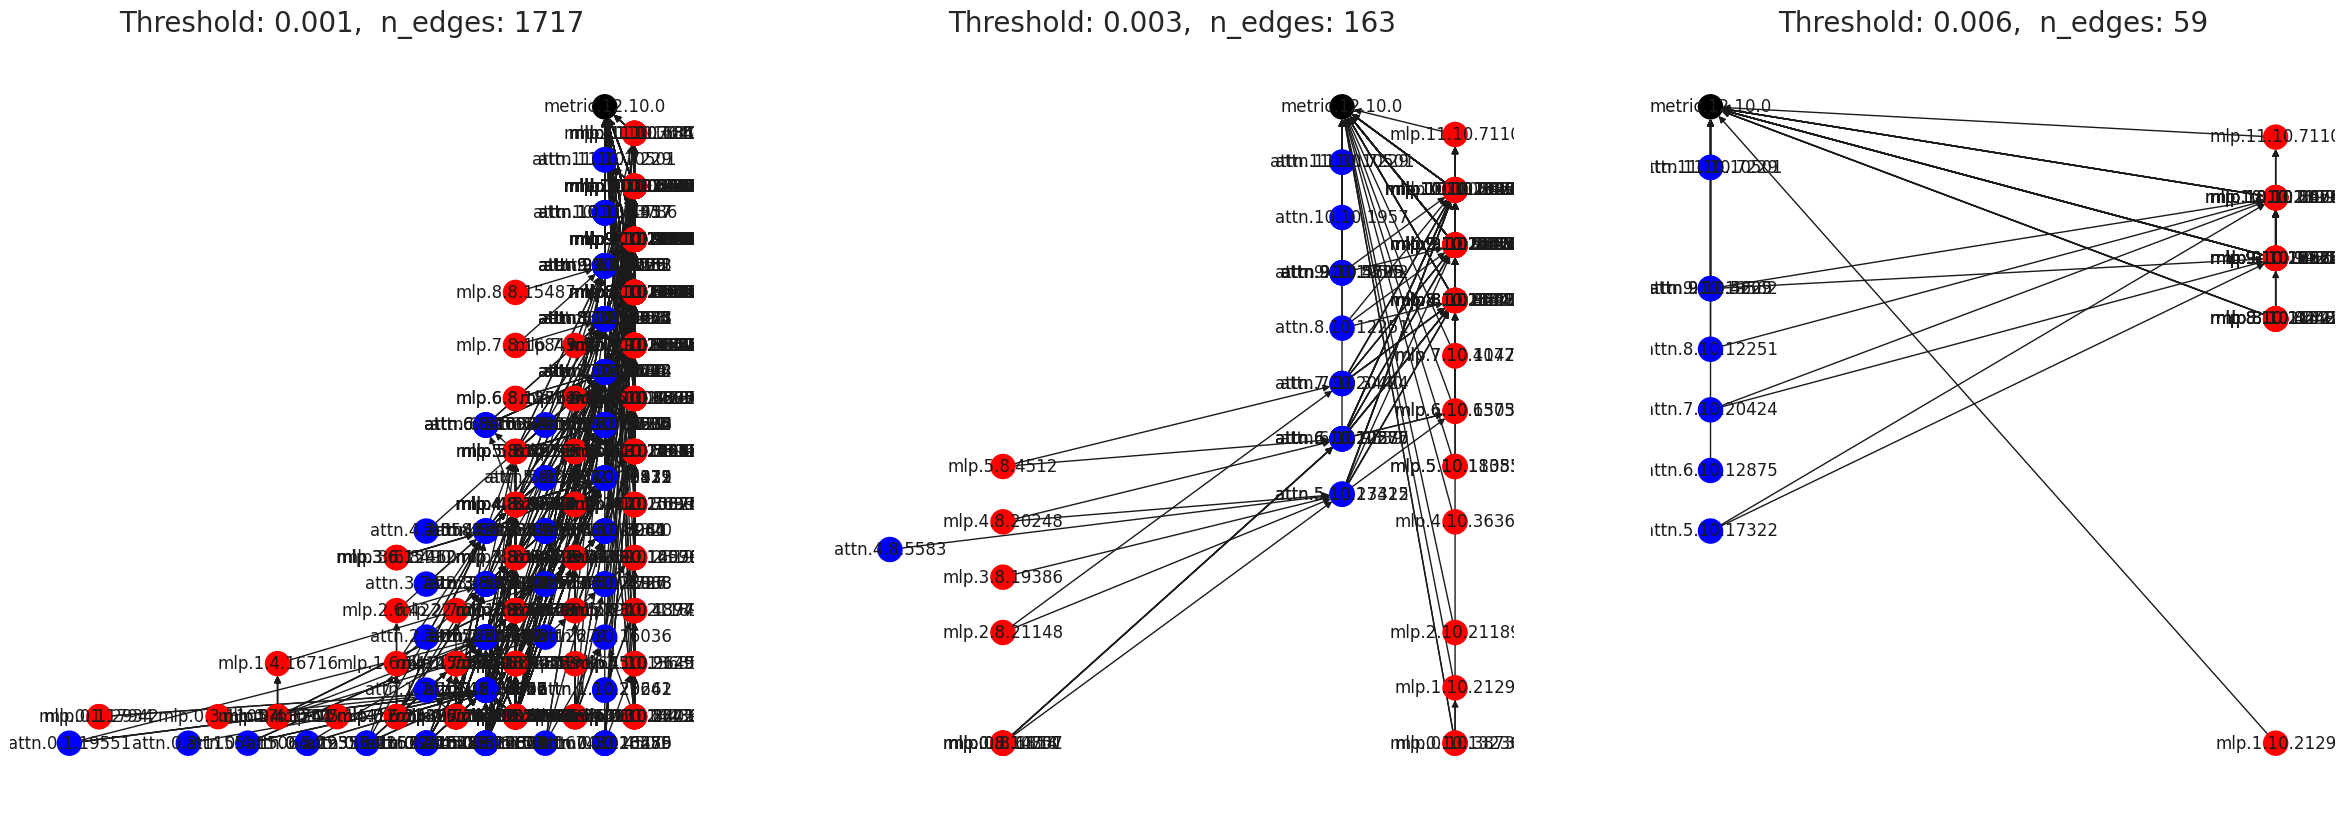

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
thresholds = [
    0.001,
    0.003,
    0.006,
    # 0.06,
]

for ax, threshold in zip(axs, thresholds):
    with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
        graph = EAPGraph.from_json(json.load(f))

    n_edges = len(graph.get_edges())
    print(f"Threshold: {threshold}, n_edges: {n_edges}")
    ax.set_title(f"Threshold: {threshold},  n_edges: {n_edges}", fontsize=20)

    if n_edges > 2000:
        continue
    show_attrib_graph(graph, ax=ax)


fig.show()

## Inspect the graph

In [7]:
threshold = 0.001
with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
    graph = EAPGraph.from_json(json.load(f))


In [8]:
## Print the distribution of nodes
import pandas as pd
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info in graph.graph:
    dest, src = edge
    if 'metric' in src: continue
    nn_grad, nn_attrib, em_grad, em_attrib = edge_info 
    src_module_type, src_layer, src_token, src_feature = parse_node_name(src)
    dest_module_type, dest_layer, dest_token, dest_feature = parse_node_name(dest)
    rows.append({
        "src_module_type": src_module_type,
        "dest_module_type": dest_module_type,
        "src_layer": src_layer,
        "dest_layer": dest_layer,
        "src_token": src_token,
        "dest_token": dest_token,
        "src_feature": src_feature,
        "dest_feature": dest_feature,
        "nn_grad": nn_grad,
        "nn_attrib": nn_attrib,
        "em_grad": em_grad,
        "em_attrib": em_attrib,
    })
df = pd.DataFrame(rows)
print(len(df))
df.head()

1706


,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,0,12,10,10,3873,0,0.000974,0.003884,0.000974,0.003884
1,mlp,metric,0,12,10,10,13236,0,0.000669,0.005625,0.000669,0.005625
2,mlp,metric,1,12,10,10,2129,0,0.001946,0.006235,0.001946,0.006235
3,mlp,metric,1,12,10,10,9645,0,0.000857,0.002293,0.000857,0.002293
4,mlp,metric,1,12,10,10,13635,0,0.000977,0.001663,0.000977,0.001663


In [16]:
df

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,0,12,10,10,3873,0,0.000974,0.003884,0.000974,0.003884
1,mlp,metric,0,12,10,10,13236,0,0.000669,0.005625,0.000669,0.005625
2,mlp,metric,1,12,10,10,2129,0,0.001946,0.006235,0.001946,0.006235
3,mlp,metric,1,12,10,10,9645,0,0.000857,0.002293,0.000857,0.002293
4,mlp,metric,1,12,10,10,13635,0,0.000977,0.001663,0.000977,0.001663
...,...,...,...,...,...,...,...,...,...,...,...,...
1701,attn,attn,0,1,8,8,6158,20641,0.073691,0.101758,0.001229,0.001696
1702,attn,attn,0,1,8,8,12302,20641,0.078973,0.106448,0.001317,0.001775
1703,attn,attn,0,1,8,8,14621,20641,0.099249,0.098090,0.001655,0.001635
1704,attn,attn,0,1,8,8,16822,20641,0.033002,0.242640,0.000550,0.004045


Index(['src_layer', 'src_module_type', 'dest_module_type', 'dest_layer',
       'src_token', 'dest_token', 'src_feature', 'dest_feature', 'nn_grad',
       'nn_attrib', 'em_grad', 'em_attrib'],
      dtype='object')


Text(0.5, 1.0, 'Total edge attribution by src layer')

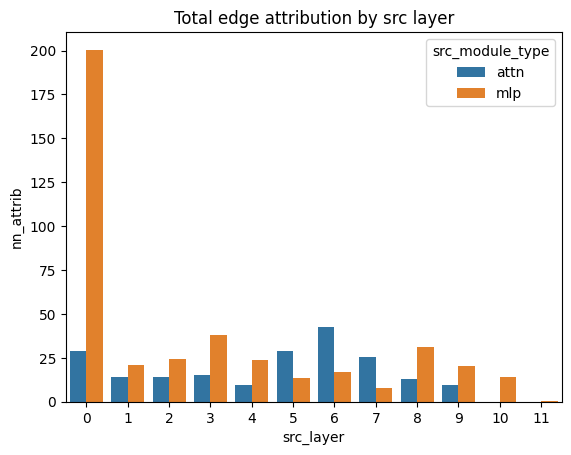

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

total_attrib_df = df.groupby(["src_layer", "src_module_type"]).sum().reset_index()
print(total_attrib_df.columns)
# Plot the total edge attribution by src layer
sns.barplot(x="src_layer", y="nn_attrib", data=total_attrib_df, hue="src_module_type")
plt.title("Total edge attribution by src layer")

Text(0.5, 1.0, 'Number of nodes in each layer')

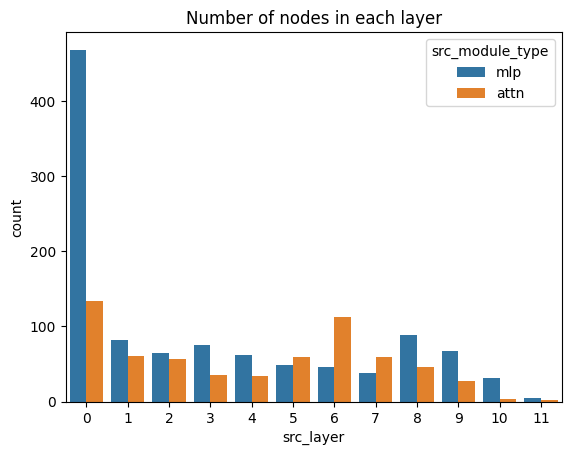

In [10]:
# Plot the number of nodes in each layer
sns.countplot(x="src_layer", data=df, hue="src_module_type")
plt.title("Number of nodes in each layer")

In [11]:
## Highest nodes by NN attrib

df.sort_values(by='em_attrib', ascending=False).head(10)

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
74,mlp,metric,10,12,10,10,1954,0,0.010125,0.146631,0.010125,0.146631
56,mlp,metric,9,12,10,10,12072,0,0.003562,0.067702,0.003562,0.067702
1654,mlp,attn,0,1,7,8,13236,15060,0.284945,2.478428,0.007599,0.066098
95,mlp,metric,11,12,10,10,7110,0,0.004631,0.054100,0.004631,0.054100
75,mlp,metric,10,12,10,10,2678,0,0.005609,0.033466,0.005609,0.033466
37,mlp,metric,8,12,10,10,11377,0,0.005222,0.031555,0.005222,0.031555
81,mlp,metric,10,12,10,10,8006,0,0.005544,0.028458,0.005544,0.028458
1653,mlp,attn,0,1,7,8,3873,15060,0.244249,0.945443,0.006514,0.025214
183,mlp,mlp,9,10,10,10,12072,1954,0.123596,2.348991,0.001323,0.025140
54,mlp,metric,9,12,10,10,9921,0,0.002910,0.023882,0.002910,0.023882


### Layer 9 Attention SAE Features

In [12]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

layer = 9

features = df[
    (df.src_layer == layer) & 
    (df.src_module_type == 'attn')
]['src_feature'].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%222753%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%224609%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225225%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225795%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2219261%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2219562%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2219188%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2219%22%7D

In [13]:
layer = 10

features = df[(df.src_layer == layer) & (df.src_module_type == "attn")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%221957%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224317%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%224437%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2213786%22%7D%5D'

In [20]:
layer = 8

features = df[(df.src_layer == layer) & (df.src_module_type == "mlp")][
    "src_feature"
].unique()

print(get_neuronpedia_url_for_quick_list(layer, features, "tres-dc"))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%223544%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%224449%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%225242%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%226085%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%228252%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%228899%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%229691%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-tres-dc%22%2C%20%22index%22%3A%20%221137

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

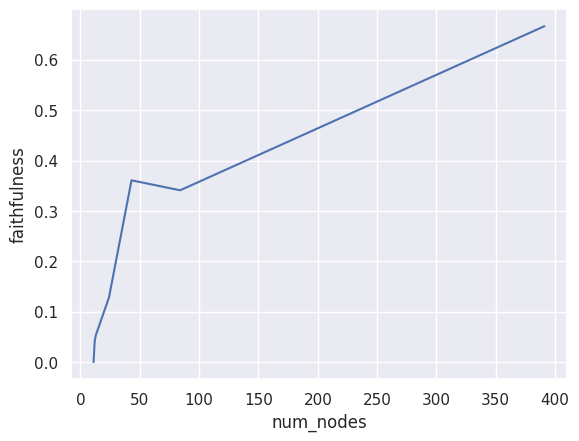

In [15]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")